#Bayesian Media Mix Modeling Challenge with PyMC3

We give two Bayesian media mix model (MMM), one that takes into account trend, seasonality and carryover and a second one that also takes into account saturation and diminishing returns. We use as the main guideline the paper [Bayesian Methods for Media Mix Modeling with Carryover and Shape Effects](https://storage.googleapis.com/pub-tools-public-publication-data/pdf/b20467a5c27b86c08cceed56fc72ceadb875184a.pdf).
&nbsp;

We also partly guide ourselves with the following sources: 

1. [Media Effect Estimation with PyMC: Adstock, Saturation & Diminishing Returns](https://juanitorduz.github.io/pymc_mmm/)
&nbsp;

2. [Air passengers - Prophet-like model
](https://docs.pymc.io/en/v3/pymc-examples/examples/time_series/Air_passengers-Prophet_with_Bayesian_workflow.html)






We first start by installing PyMC3 and importing the necessary libraries.

In [ ]:
pip install pymc3

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
import arviz as az
import pymc3 as pm
import theano
import theano.tensor as tt

plt.style.use("seaborn")

## 1. Description of our data

We now import our data, normalize it and make the first analysis. 

The data contains:

1. Weekly revenue
2. Weekly spend of seven media channels


In [ ]:
data = pd.read_csv(
    'MMM_test_data.csv')
   
print(data)
data.info()

    start_of_week    revenue  spend_channel_1  spend_channel_2  \
0        30-08-20  157906.75          2625.48           262.71   
1        06-09-20  186425.68          2634.01           108.66   
2        13-09-20  161607.39          2087.08           110.32   
3        20-09-20  180089.13          1690.70            52.79   
4        27-09-20  217793.98          1547.30            80.56   
..            ...        ...              ...              ...   
99       24-07-22   72021.50             0.00          1118.78   
100      31-07-22   90786.21             0.00           122.16   
101      07-08-22  105929.40             0.00           754.09   
102      14-08-22   90506.31             0.00          1043.22   
103      21-08-22   84394.50             0.00           387.94   

     spend_channel_3  spend_channel_4  spend_channel_5  spend_channel_6  \
0           12954.12          3609.63         12955.29         12659.12   
1            8760.28          4560.60         12747.70   

In [87]:
data['start_of_week'] = pd.to_datetime(data['start_of_week'], errors='coerce')
Y=data.copy()
Z=data.drop(columns=['start_of_week'])
Z_norm = Z/Z.max()
X = Z_norm.drop(columns=['revenue'])
Y['revenue']=Z_norm['revenue']
y = Z_norm['revenue']
print(Z.max())


revenue            418186.38
spend_channel_1      8513.83
spend_channel_2      1605.85
spend_channel_3     49689.38
spend_channel_4     22629.69
spend_channel_5     33009.65
spend_channel_6     33692.83
spend_channel_7     77488.42
dtype: float64


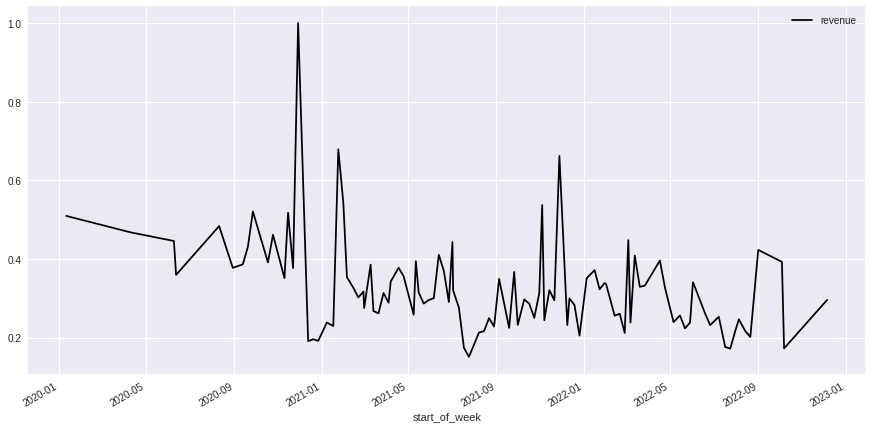

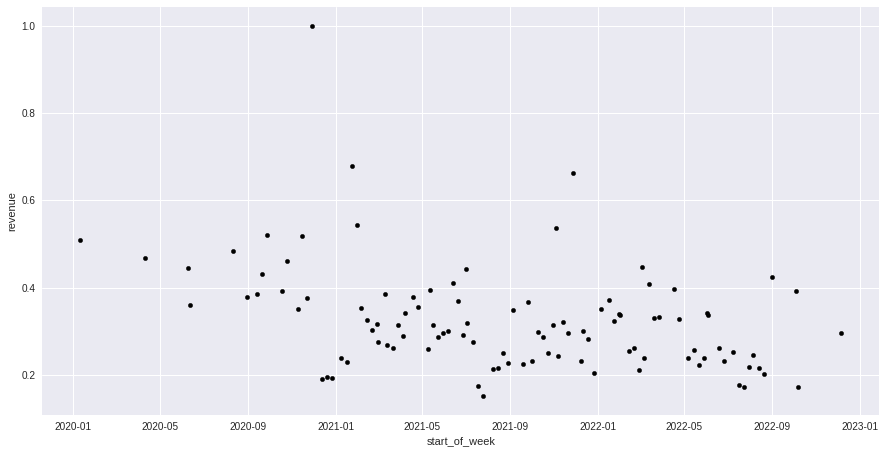

In [ ]:
Y.plot.line(x='start_of_week', y='revenue',color='k',figsize=(15,7.5))
Y.plot.scatter(x='start_of_week', y='revenue',color='k', figsize=(15,7.5))



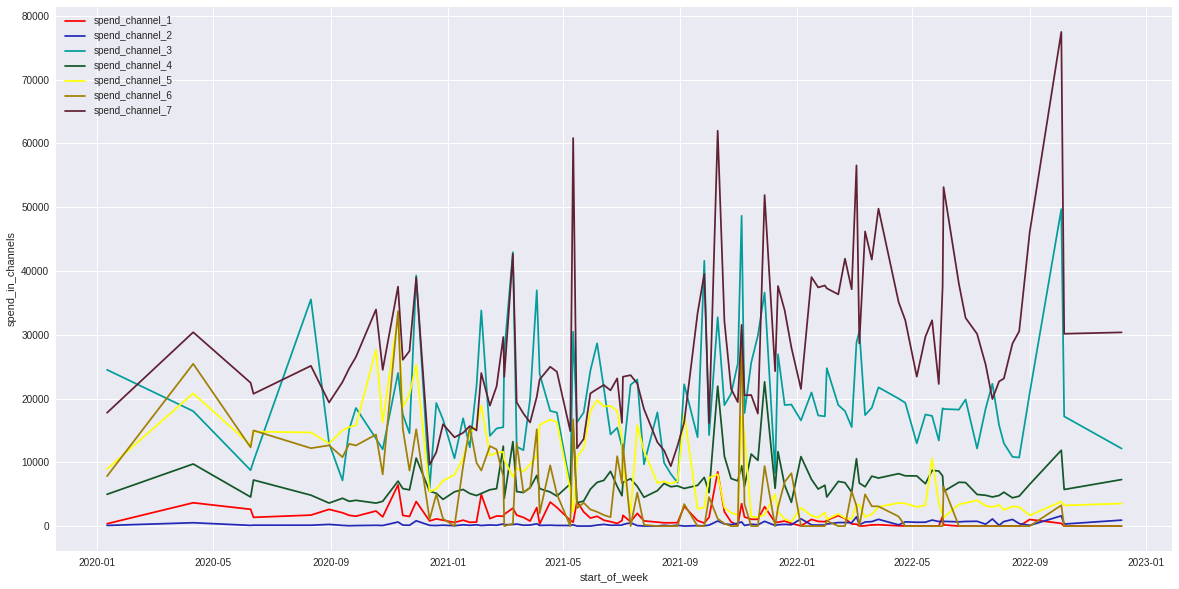

In [ ]:
fig,ax=plt.subplots(figsize=(20, 10))
sns.lineplot(x=Y['start_of_week'], y=Y['spend_channel_1'],color='red',label="spend_channel_1")
sns.lineplot(x=Y['start_of_week'], y=Y['spend_channel_2'],color='#2429b5',label="spend_channel_2")
sns.lineplot(x=Y['start_of_week'], y=Y['spend_channel_3'],color='#039e9c',label="spend_channel_3")
sns.lineplot(x=Y['start_of_week'], y=Y['spend_channel_4'],color='#145729',label="spend_channel_4")
sns.lineplot(x=Y['start_of_week'], y=Y['spend_channel_5'],color='yellow',label="spend_channel_5")
sns.lineplot(x=Y['start_of_week'], y=Y['spend_channel_6'],color='#a17f05',label="spend_channel_6")
sns.lineplot(x=Y['start_of_week'], y=Y['spend_channel_7'],color='#612134',label="spend_channel_7")
ax.set(xlabel='start_of_week', ylabel='spend_in_channels')
plt.legend()


## 2. Description of the model

The revenue acquired each week (y_t) is modeled using weekly marketing spending for the different channels while controlling external factors (seasonality and trend). The model produces a coefficient (beta_m) for each channel that represents revenue that is acquired for each euro spent (holding other spending constant). The equation of the model that we are using is:

$y_t=\tau + \sum \limits^M_{m=1}\beta_{m}Hill(x^{*}_{m,t})+ tc_{trend}+\gamma_t c_{seasonality}+\epsilon$


We are going to explain in detail each term of this equation below. Briefly, $\tau$ is the base and $x^*_{m,t}$ is the image of a function on $x_{m}$ that takes into account the carryover (delayed adstock) of the channel. Hill is a function that models the saturation and diminishing returns of a media channel. We use a linear trend, for the seasonality $\gamma(t)$ is a function that gives a periodic effect and $\epsilon$ is the noise.

Remark: It is mentioned in every source and it is relevant to mention it here that we choose to first apply the delayed adstock function and then the Hill function because the media spend in each time period is relatively small compared to the cumulative spend across multiple time periods.

## 3. Preparation of our model

## Priors


We follow the recommendations of [Prior Choice Recommendations](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations) and the suggestions of Table 3. Prior of Parameters of the paper [Bayesian Methods for Media Mix Modeling with Carryover and Shape Effects](https://storage.googleapis.com/pub-tools-public-publication-data/pdf/b20467a5c27b86c08cceed56fc72ceadb875184a.pdf)

1. Base and noise ($\tau$ and $\epsilon$)

2. Trend ($t$ and $c_{trend}$)

3. Seasonality($\gamma(t)$ and $c_{seasonality}$)

4. Carryover(Delayed adstock)

5. Saturation(Hill)

6. Media coefficients($\beta_m$)

### 3.1 Base and Noise

### Priors 

1. For the base $\tau$, we choose a pm.Normal(0,3)
2. For the noise $\epsilon$, we choose a pm.HalfNormal(0.05). 

###3.2 Trend

To give the general tendency of the revenue, we use a linear trend. We choose as a prior for $c_{trend}$ as a pm.Normal(0,1) as a coefficient that could affect positively or negatively the sales. We define $t$ as a linear parameter (between 0 and 1) defined below.

In [ ]:
Y['start_of_week'] = pd.to_datetime(data["start_of_week"])
t = Y["start_of_week"].to_numpy()
t_min = np.min(t)
t_max = np.max(t)
t = (t - t_min) / (t_max - t_min)

print(t)

[0.21886792 0.14150943 0.23207547 0.23867925 0.24528302 0.08490566
 0.28679245 0.26509434 0.27169811 0.         0.2009434  0.29150943
 0.29811321 0.30471698 0.14433962 0.31792453 0.3245283  0.33113208
 0.39150943 0.59339623 0.3509434  0.35754717 0.36415094 0.50754717
 0.37735849 0.38396226 0.39056604 0.50849057 0.40377358 0.41037736
 0.41698113 0.42358491 0.6254717  0.43679245 0.44339623 0.36886792
 0.56886792 0.46320755 0.46981132 0.47641509 0.48301887 0.48962264
 0.49622642 0.50283019 0.42641509 0.62830189 0.52264151 0.52924528
 0.34245283 0.54245283 0.5490566  0.55566038 0.56226415 0.45660377
 0.65849057 0.58207547 0.58867925 0.4        0.60188679 0.60849057
 0.61509434 0.62169811 0.51603774 0.63490566 0.64150943 0.64811321
 0.45943396 0.66132075 0.66792453 0.6745283  0.70943396 0.90943396
 0.69433962 0.7009434  0.70754717 0.82358491 0.72075472 0.72735849
 0.73396226 0.8245283  0.74716981 0.75377358 0.76037736 0.73867925
 0.94056604 0.78018868 0.78679245 0.68396226 0.88396226 0.8066

## 3.3 Seasonality 

In order to find the recurrent pattern at regular time intervals, we follow []() and more precisely directly from [](). We use Fourier series to give the periodic effect. We construct a matrix of seasonality vectors of each t. 
$$\gamma(t)=[\frac{\cos(2*\pi)}{365.25},\cdots,\frac{\sin(2\pi(10))}{365.25}].$$ 
We then obtain that $$seasonality=\gamma(t)c_{seasonality}.$$ 

###Priors
For $c_{seasonality}$, we choose a pm.Normal$(0,0.25)$ to "impose a smoothing prior of the seasonality". In our model, we are going to use an additive seasonality. 


Below, we take the following features from [Forescasting at scale](https://peerj.com/preprints/3190.pdf) and [Air passengers - Prophet-like]((https://docs.pymc.io/en/v3/pymc-examples/examples/time_series/Air_passengers-Prophet_with_Bayesian_workflow.html)) model to model $\gamma(t).$

In [ ]:
n_order = 10
periods = data["start_of_week"].dt.dayofyear / 365.25
print(periods)
fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)


0      0.665298
1      0.440794
2      0.703628
3      0.722793
4      0.741958
         ...   
99     0.561259
100    0.580424
101    0.517454
102    0.618754
103    0.637919
Name: start_of_week, Length: 104, dtype: float64


## 3.4 Carryover effect (Delayed adstock)
 

 


To model the impact of media spend over a future period, we use a delayed adstock function by following Section 2.1 in [Bayesian Methods for Media Mix Modeling with Carryover and Shape Effects](https://storage.googleapis.com/pub-tools-public-publication-data/pdf/b20467a5c27b86c08cceed56fc72ceadb875184a.pdf). A geometric adstock function assumes that advertising effect peaks at the same time as the ad exposure, here we assume that the effect does not happen inmediately. Here, the carryover effect describes the lag between the time a consumer sees an ad and the time a consumer converts because of the ad. It also describes how the marketing signal decreases over time.

The delayed adstock function as described in Section 2.1  and defined below depends of the following variables:

1. $\alpha \in (0,1)$ is the retention rate of ad effect of the media channel from one period to the next (The higher the decay, the more scattered the effect and the longer the effect in time for that specific channel media exposure.)
2. $\theta$ is the delay of the peak effect
3. $L$ maximum durations of the carryover effect measured in weeks (same for all channels).

### Priors 
1. For $\alpha,$ we choose a pm.Beta(3,3). It would give us a positive number in (0,1).
2. For $\theta,$ we choose a pm.Uniform(0,12).
3. We set $L=13$ as suggested in the paper. 




In [ ]:
def delayed_adstock(x, theta, alpha, L):
    """Function that gives the carryover effect of a media channel

    alpha: is the retention rate
    theta: delay of the peak effect
    L: maximum duration of the carryover effect measure in weeks"""
    
    w = tt.as_tensor_variable([tt.power(alpha,tt.power(i-theta,2)) for i in range(L)])
    xx = tt.stack([tt.concatenate([tt.zeros(i), x[:x.shape[0] -i]]) for i in range(L)])

    return tt.dot(w/tt.sum(w), xx)
    


## 3.5 Saturation and diminishing returns

To model the diminishing returns, we follow Section 2.2 in 
[Bayesian Methods for Media Mix Modeling with Carryover and Shape Effects](https://storage.googleapis.com/pub-tools-public-publication-data/pdf/b20467a5c27b86c08cceed56fc72ceadb875184a.pdf).

That is when a media channel begins to lose its effectiveness i.e. the difference between spending 0 and 50 EUR is larger than 100 and 150 EUR. 
After a certain point, the revenue through media spending would get to its limit and further media spending would have a non significant incremental effect on the revenue.

We use the Hill function as defined below. The function depends on the following variables:


1. $\mathcal{K}>0$ is the half saturation point i.e. the bigger $\mathcal{K}>0$ is, the harder it is to saturate the associated media channel.
2. $\mathcal{S}>0$ shape parameter, refered as slope. In other words, the bigger $\mathcal{S}$ is, the bigger are the marginal gains for investments around the half saturation point.

### Priors 

1. For $\mathcal{K},$ we choose a pm.Beta(2,2)
2. For $\mathcal{S},$ we choose a pm.Gamma(3,1)







In [ ]:
def Hill(x, S, K):
    return 1 - (K**S)/(x**S+K**S)

## 3.6 Media Coefficients ($\beta_m$)

### Priors
For our media coefficients, we are going to assume that if we invest in a media channel there is always some profit i.e. that  $\beta_m>0.$ For our $\beta_m,$ we choose a pm.HalfNormal(1). It plays two roles, it ensures that the media coefficients are positive and it also regularizes them at the same time. It gives a smoother and stabler inference that a flat prior.  

## 4. The Models

 ## 4.1 Model 1 (Seasonality, Trend and Carryover)

In our first model we only consider seasonality, trend and carryover. 

Following the comments in [
Improving the Speed and Accuracy of Bayesian Media Mix Models](https://www.pymc-labs.io/blog-posts/reducing-customer-acquisition-costs-how-we-helped-optimizing-hellofreshs-marketing-budget/) "we reduced undesired effects on the parameter estimates by outlier data points by switching from a Normal likelihood function to a Student T distribution which is more robust to outliers"
To give the equation of our model, we are going to use either a pm.Normal() or a pm.StudentT.

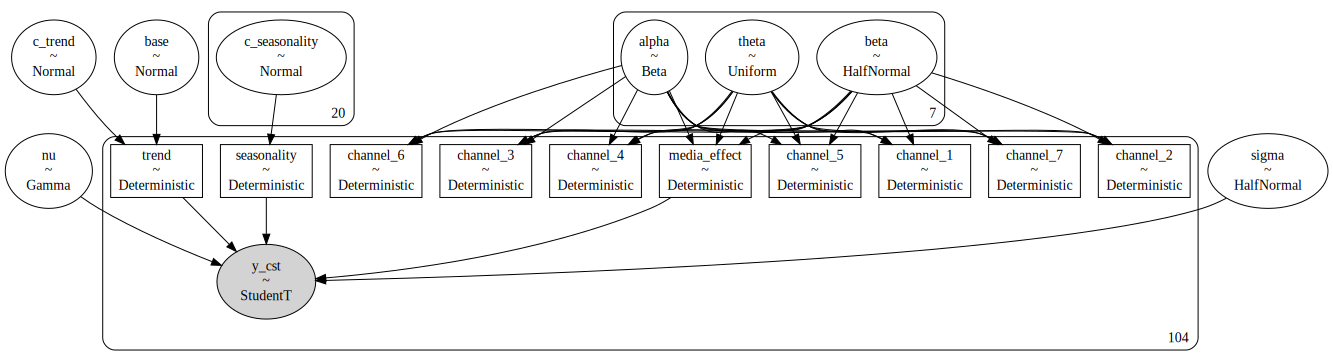

In [141]:
import pymc3 as pm


coords = {"fourier_features": np.arange(2 * n_order)}

with pm.Model(coords=coords) as mmm_cst:
    #priors
    #base
    base=pm.Normal(name='base',mu=0, sigma=3)
    #trend
    c_t=pm.Normal(name='c_trend',mu=0, sigma=1)
    #seasonality
    c_s=pm.Normal(name='c_seasonality',mu=0, sigma=0.25, dims='fourier_features')
    
    #carry_over
    alpha = pm.Beta('alpha',           3 , 3,   shape=X.shape[1]) # retain rate in adstock 
    theta = pm.Uniform('theta',        0 , 12,  shape=X.shape[1]) #pick/delay of media impact
    beta= pm.HalfNormal('beta', 1,  shape=X.shape[1]) #media coefficients
    #parametrization
    trend = pm.Deterministic("trend", base+c_t*t)
    seasonality = pm.Deterministic(
        "seasonality", pm.math.dot(c_s, fourier_features.to_numpy().T))
    computations = []
    for idx,col in enumerate(X.columns):
        comp = delayed_adstock(x=X[col].values, 
                                                alpha=alpha[idx],
                                                theta=theta[idx],
                                                L=13)*beta[idx]  
        
        computations.append(comp)
   
    
    media_effect=pm.Deterministic('media_effect', sum(computations))
    channel_1=pm.Deterministic('channel_1', computations[0])
    channel_2=pm.Deterministic('channel_2', computations[1])
    channel_3=pm.Deterministic('channel_3', computations[2])
    channel_4=pm.Deterministic('channel_4', computations[3])
    channel_5=pm.Deterministic('channel_5', computations[4])
    channel_6=pm.Deterministic('channel_6', computations[5])
    channel_7=pm.Deterministic('channel_7', computations[6])





    #likelihood
    nu=pm.Gamma(name='nu',alpha=25,beta=2)
    sigma = pm.HalfNormal('sigma', 0.05)
    mu = media_effect+ trend+seasonality + sigma
    y_cst = pm.StudentT('y_cst', mu=mu, nu=nu, sigma=sigma, 
                  observed=y)
  
    mmm_cst_prior_predictive = pm.sample_prior_predictive()
pm.model_to_graphviz(model=mmm_cst)



## 4.1.1 Prior Checks




In [142]:
RANDOM_SEED = 4000
rng = np.random.default_rng(RANDOM_SEED)

def _sample(array, n_samples):
    """Function that sample n_samples with replacement"""
    idx = np.random.choice(np.arange(len(array)), n_samples, replace=True)
    return array[idx]

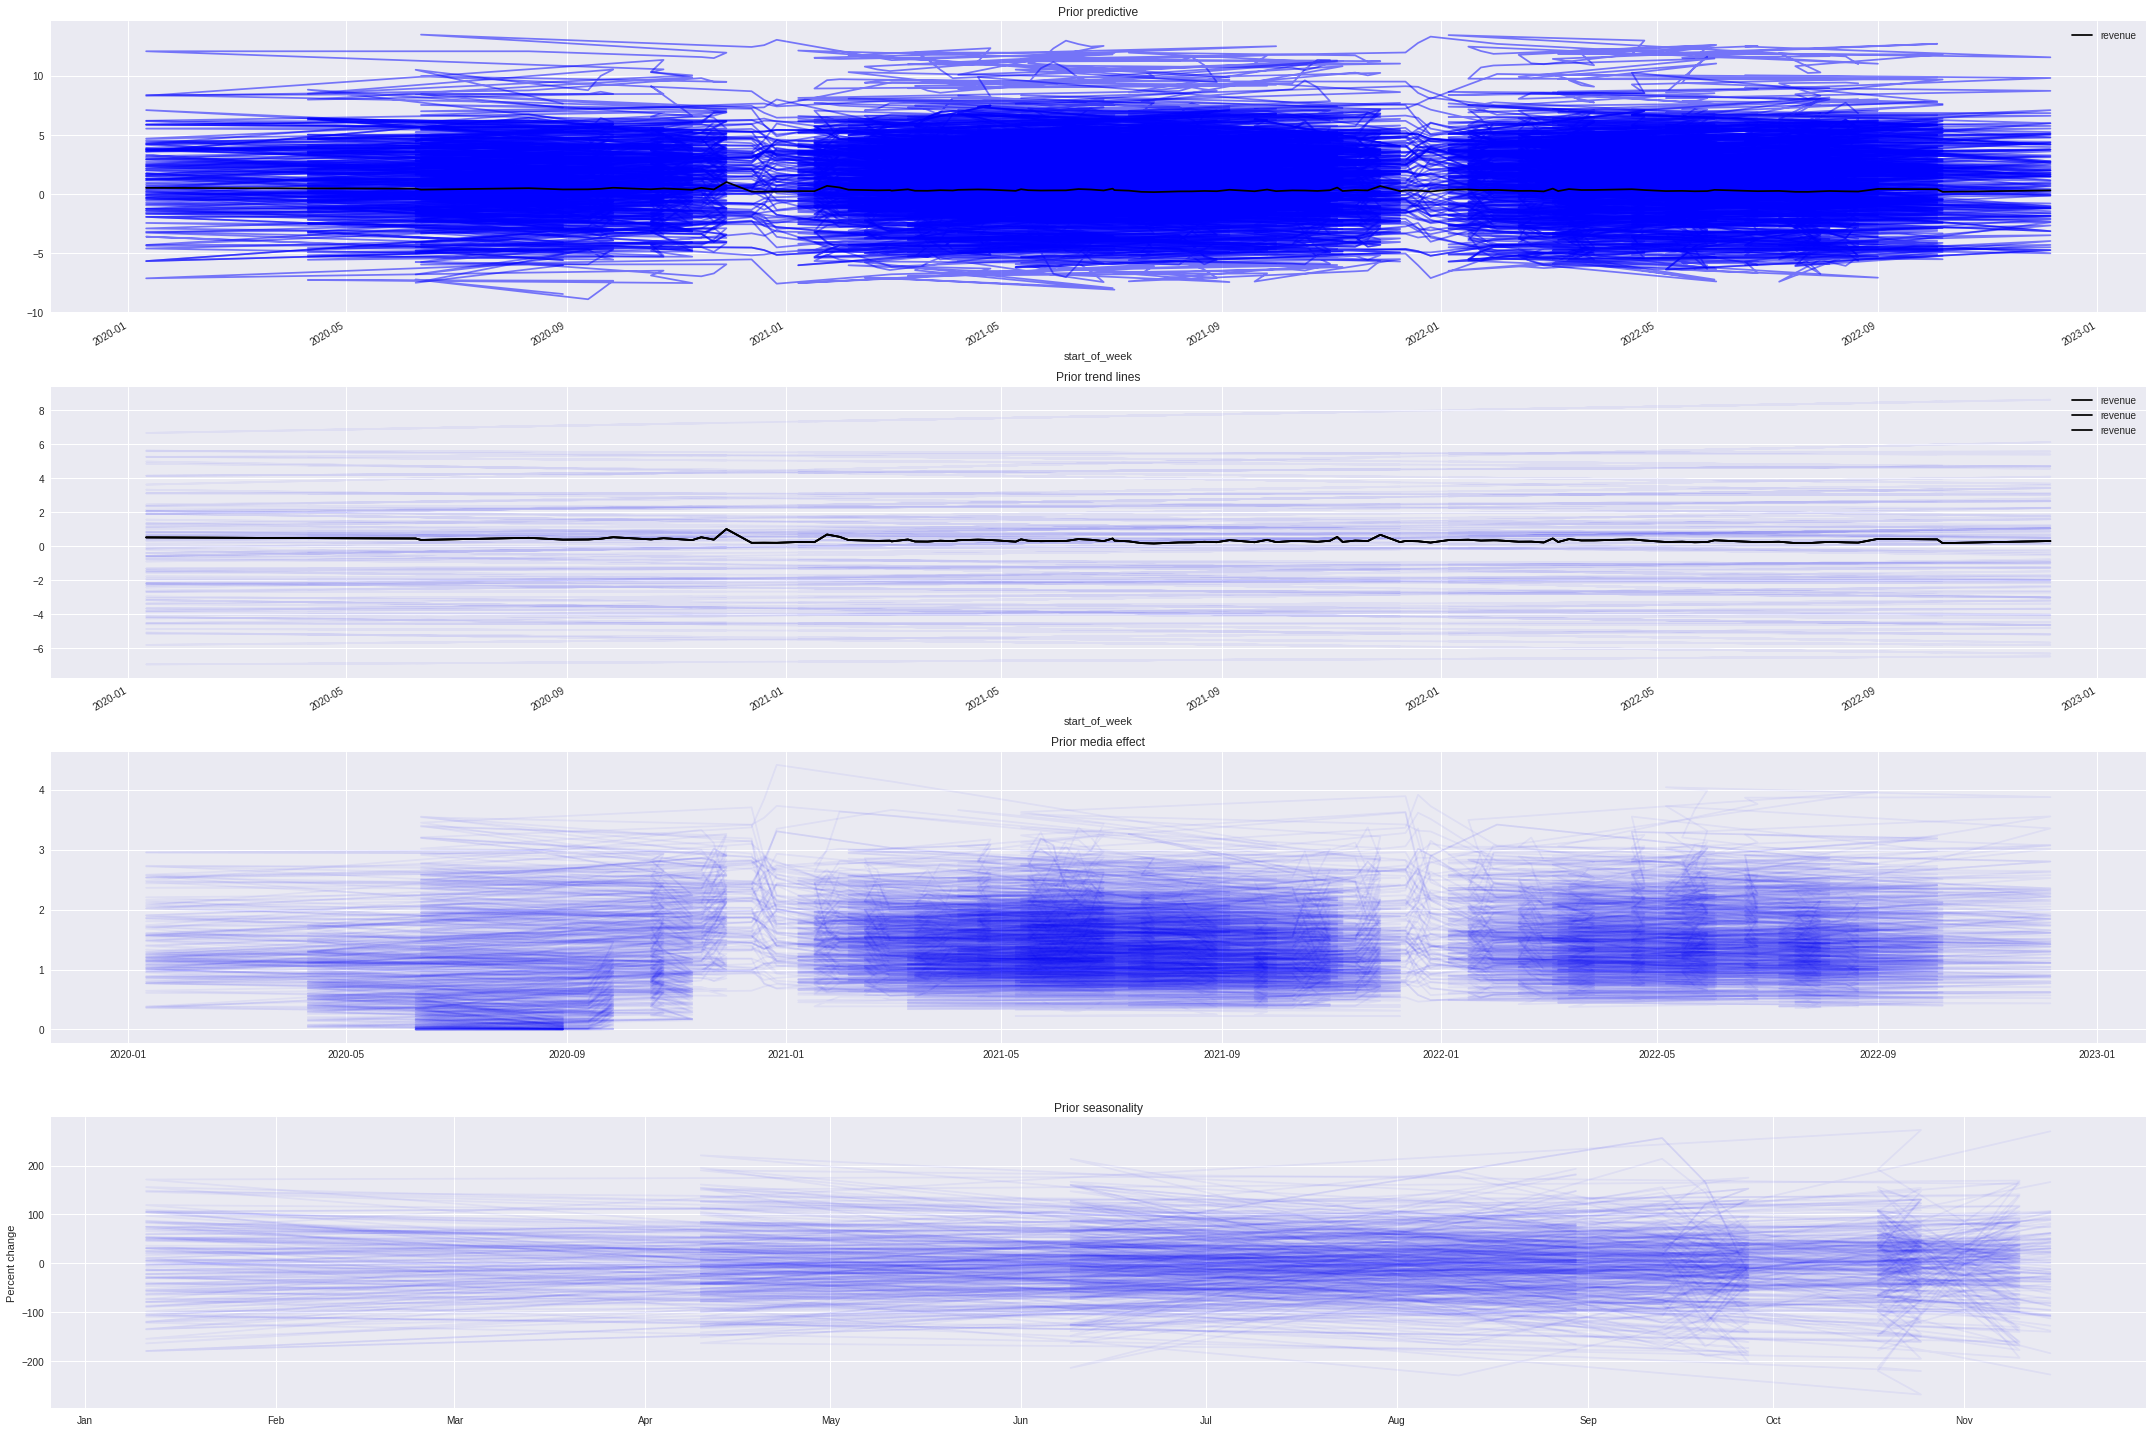

In [143]:
#Verifying priors

fig, ax = plt.subplots(nrows=4, ncols=1, sharex=False, figsize=(30, 20))
ax[0].plot(
    Y["start_of_week"],
    _sample(mmm_cst_prior_predictive['y_cst'], 100).T,
    color="blue",
    alpha=0.5,
)

Y.plot.line(x="start_of_week", y="revenue", color="k", ax=ax[0])
ax[0].set_title("Prior predictive");
ax[1].plot(
    Y["start_of_week"], _sample(mmm_cst_prior_predictive["trend"], 104).T , color="blue", alpha=0.05
)
Y.plot.line(x="start_of_week", y="revenue", color="k", ax=ax[1])
ax[1].set_title("Prior trend lines");
ax[2].plot(
    Y["start_of_week"], _sample(mmm_cst_prior_predictive["media_effect"], 104).T , color="blue", alpha=0.05
)
Y.plot.line(x="start_of_week", y="revenue", color="k", ax=ax[1])
ax[2].set_title("Prior media effect")
Y.plot.line(x="start_of_week", y="revenue", color="k", ax=ax[1]);

ax[3].plot(
    Y["start_of_week"].iloc[:12],
    _sample(mmm_cst_prior_predictive["seasonality"][:, :12], 100).T * 100,
    color="blue",
    alpha=0.05,
)
ax[3].set_title("Prior seasonality")
ax[3].set_ylabel("Percent change")
formatter = mdates.DateFormatter("%b")
ax[3].xaxis.set_major_formatter(formatter);
fig.tight_layout()

The prior checks look reasonable, since the range variables do not seems out of control.

We now fit our model. We PyMC and MCMC to produce our posterior. 



In [144]:
with mmm_cst:
    
    mmm_cst_trace = pm.sample(1000, return_inferencedata=True,tune=4000, target_accept=0.9)
    pp_mmm_cst= pm.sample_posterior_predictive(trace=mmm_cst_trace)

## 4.1.2 Posterior Checks 

In order to check that our posterior is good enough, we follow the guideline of Section 2.4. in [Diagnosing Numerical Inference](https://bayesiancomputationbook.com/markdown/chp_02.html#pymc3-models-for-loo).

1. Trace plot: Here we are able to see if the different chains converge to the same distribution. In the right, we see the draws ordered by iteration, it should look noisy without particular patterns, such that we cannot distinguish the different chains. 

2. Monte Carlo Standard Error: Here we should have $r_{hat}\leq 1.01$, $ess_{bulk}$ and $ess_{tail}>>100$ and the Mote Carlo standard error $mcse_{mean}$ and $mcse_{sd}$ should be below the second decimal. We should check $mcse$ only when $ess$ is big enough and $r_{hat}\leq 1.01.$



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7f65a4c450>,
      dtype=object)

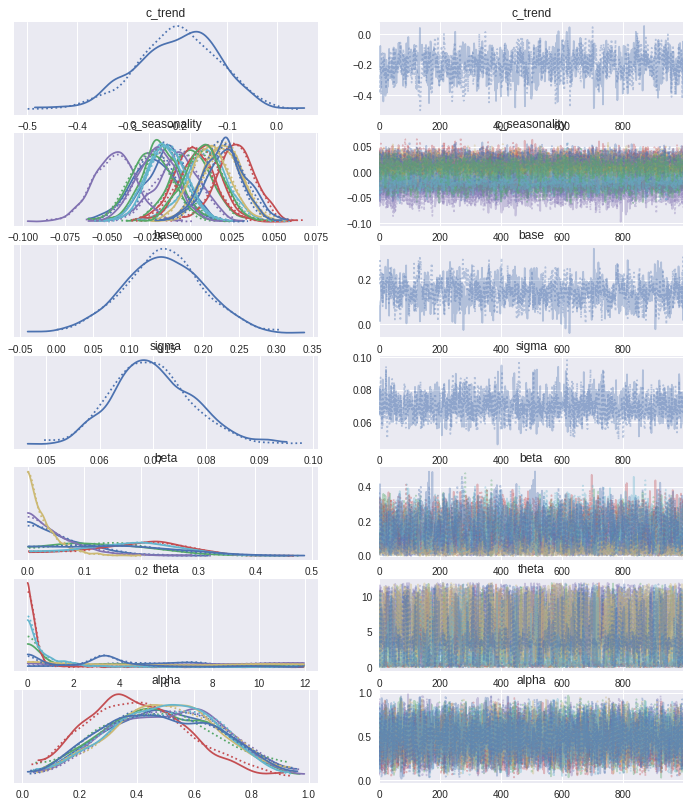

In [145]:
plt.style.use("seaborn")

az.plot_trace(data=mmm_cst_trace, var_names=['c_trend',"c_seasonality",'base','sigma', 'beta','theta','alpha'])


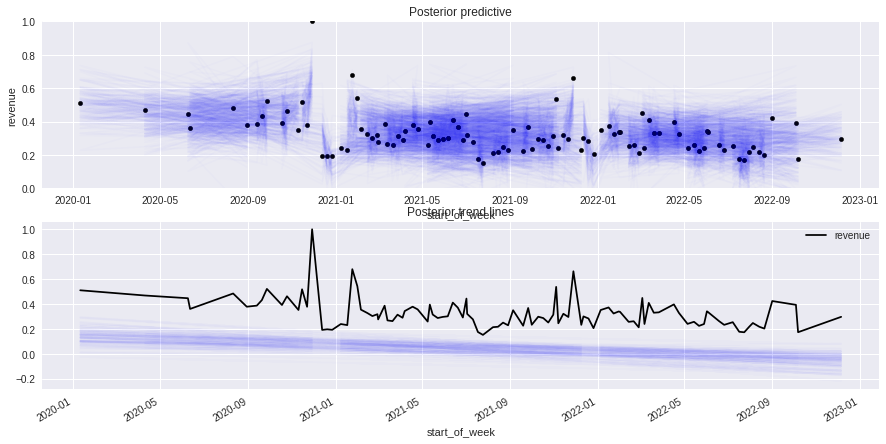

In [146]:
plt.style.use("seaborn")

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=False,figsize=(15, 7.5))
ax[0].plot(
    Y["start_of_week"],
    _sample(pp_mmm_cst["y_cst"], 104).T ,
    color="blue",
    alpha=0.01,
)
Y.plot.scatter(x="start_of_week", y="revenue", color="k", ax=ax[0])
ax[0].set_title("Posterior predictive")
ax[0].set_ylim([0, 1]);

posterior_trend = mmm_cst_trace.posterior["trend"].stack(sample=("draw", "chain")).T
ax[1].plot(data["start_of_week"], _sample(posterior_trend, 104).T , color="blue", alpha=0.01)
Y.plot.line(x="start_of_week", y="revenue", color="k", ax=ax[1])
ax[1].set_title("Posterior trend lines");
posterior_seasonality = (
    mmm_cst_trace.posterior["seasonality"].stack(sample=("draw", "chain")).T
);


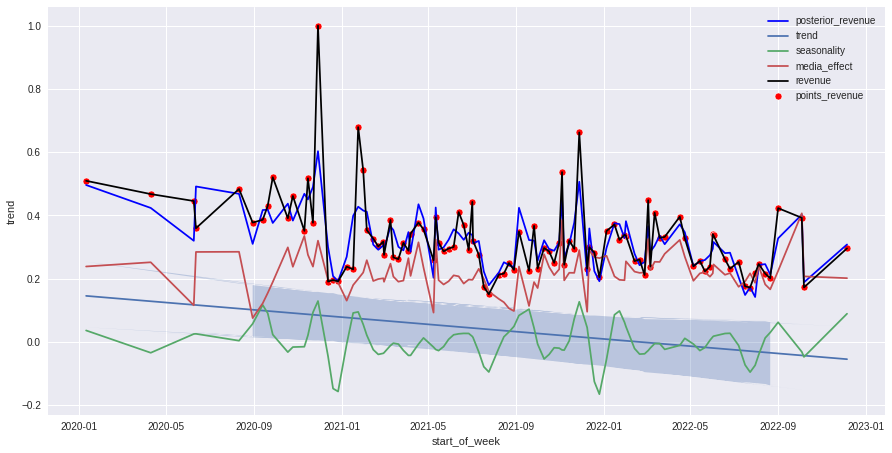

In [147]:
model_hdi=az.hdi(ary=mmm_cst_trace)
fig,ax=plt.subplots(figsize=(15, 7.5))

ax.fill_between(
    x=Y['start_of_week'],
    y1=model_hdi['trend'][:,0],
    y2=model_hdi['trend'][:,1],
    alpha=0.3,
)

sns.lineplot(
    x=Y['start_of_week'],
    y=_sample(pp_mmm_cst["y_cst"], 104).T.mean(axis=1),
    label='posterior_revenue',
    color='blue'
)

sns.lineplot(
    x=Y['start_of_week'],
    y=mmm_cst_trace.posterior['trend'].stack(sample=('chain','draw')).mean(axis=1),
    label='trend'
)

sns.lineplot(
    x=Y['start_of_week'],
    y=mmm_cst_trace.posterior['seasonality'].stack(sample=('chain','draw')).mean(axis=1),
    label='seasonality'
)

sns.lineplot(
    x=Y['start_of_week'],
    y=mmm_cst_trace.posterior['media_effect'].stack(sample=('chain','draw')).mean(axis=1),
    label='media_effect'
)
sns.lineplot(
    x=Y["start_of_week"], 
    y=Y["revenue"], 
    color="k",
    label='revenue'
)
sns.scatterplot(
    x=Y["start_of_week"], 
    y=Y["revenue"], 
    color="red",
    label='points_revenue'
)

We could clearly see that the model captures well the trend and the seasonality.



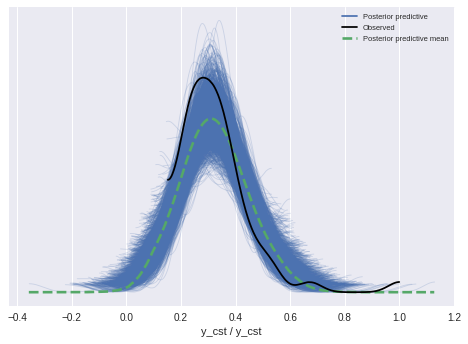

In [149]:
az.plot_ppc(az.from_pymc3(posterior_predictive=pp_mmm_cst, model=mmm_cst))
plt.show()

In [151]:
pm.summary(mmm_cst_trace, var_names=['base','alpha','theta','beta','sigma','c_trend'])
    

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
base      0.146  0.055   0.047    0.254      0.003    0.002     473.0   
alpha[0]  0.497  0.191   0.152    0.848      0.003    0.002    3034.0   
alpha[1]  0.480  0.197   0.153    0.876      0.004    0.003    2754.0   
alpha[2]  0.407  0.177   0.104    0.744      0.004    0.003    2325.0   
alpha[3]  0.510  0.191   0.172    0.858      0.003    0.003    3405.0   
alpha[4]  0.503  0.183   0.151    0.828      0.003    0.002    4165.0   
alpha[5]  0.494  0.184   0.151    0.817      0.004    0.003    2709.0   
alpha[6]  0.485  0.200   0.136    0.844      0.004    0.003    2494.0   
theta[0]  6.430  2.934   1.763   11.894      0.080    0.061    1459.0   
theta[1]  2.688  3.191   0.000    9.739      0.168    0.119     386.0   
theta[2]  0.821  1.962   0.000    4.033      0.112    0.079     465.0   
theta[3]  6.526  3.668   0.006   11.403      0.090    0.063    1702.0   
theta[4]  5.535  3.806   0.004   11.224      0.095    0.067    1834.0   
theta[5]  1.160  1.941   0.000    4.012      0.119    0.084     470.0   
theta[6]  3.448  2.611   0.000    9.259      0.131    0.093     262.0   
beta[0]   0.065  0.055   0.000    0.164      0.002    0.001    1288.0   
beta[1]   0.138  0.081   0.002    0.273      0.004    0.003     488.0   
beta[2]   0.192  0.084   0.030    0.338      0.004    0.003     483.0   
beta[3]   0.054  0.049   0.000    0.142      0.001    0.001    1195.0   
beta[4]   0.031  0.030   0.000    0.085      0.001    0.001    1317.0   
beta[5]   0.182  0.083   0.012    0.317      0.005    0.003     324.0   
beta[6]   0.155  0.096   0.001    0.318      0.005    0.004     411.0   
sigma     0.070  0.007   0.056    0.084      0.000    0.000    1296.0   
c_trend  -0.200  0.085  -0.352   -0.039      0.004    0.003     479.0   

          ess_tail  r_hat  
base        1020.0   1.00  
alpha[0]    1412.0   1.00  
alpha[1]    1195.0   1.00  
alpha[2]     965.0   1.01  
alpha[3]    1155.0   1.00  
alpha[4]    1259.0   1.00  
alpha[5]    1479.0   1.00  
alpha[6]    1370.0   1.00  
theta[0]    1000.0   1.00  
theta[1]    1228.0   1.01  
theta[2]     395.0   1.01  
theta[3]    1121.0   1.00  
theta[4]    1201.0   1.00  
theta[5]     369.0   1.01  
theta[6]     550.0   1.01  
beta[0]     1281.0   1.00  
beta[1]      845.0   1.01  
beta[2]      423.0   1.01  
beta[3]      832.0   1.00  
beta[4]      918.0   1.00  
beta[5]      398.0   1.01  
beta[6]      820.0   1.00  
sigma       1474.0   1.00  
c_trend      875.0   1.00

Here we can see, that in all the cases $r_{hat}\leq 1.01$ and that $ess_{bulk}$ and $ess_{tail}$ are always bigger than 100. Howeve, some of the $mcse_{mean}$ of theta are not satisfactory. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7f8eb97bd0>,
      dtype=object)

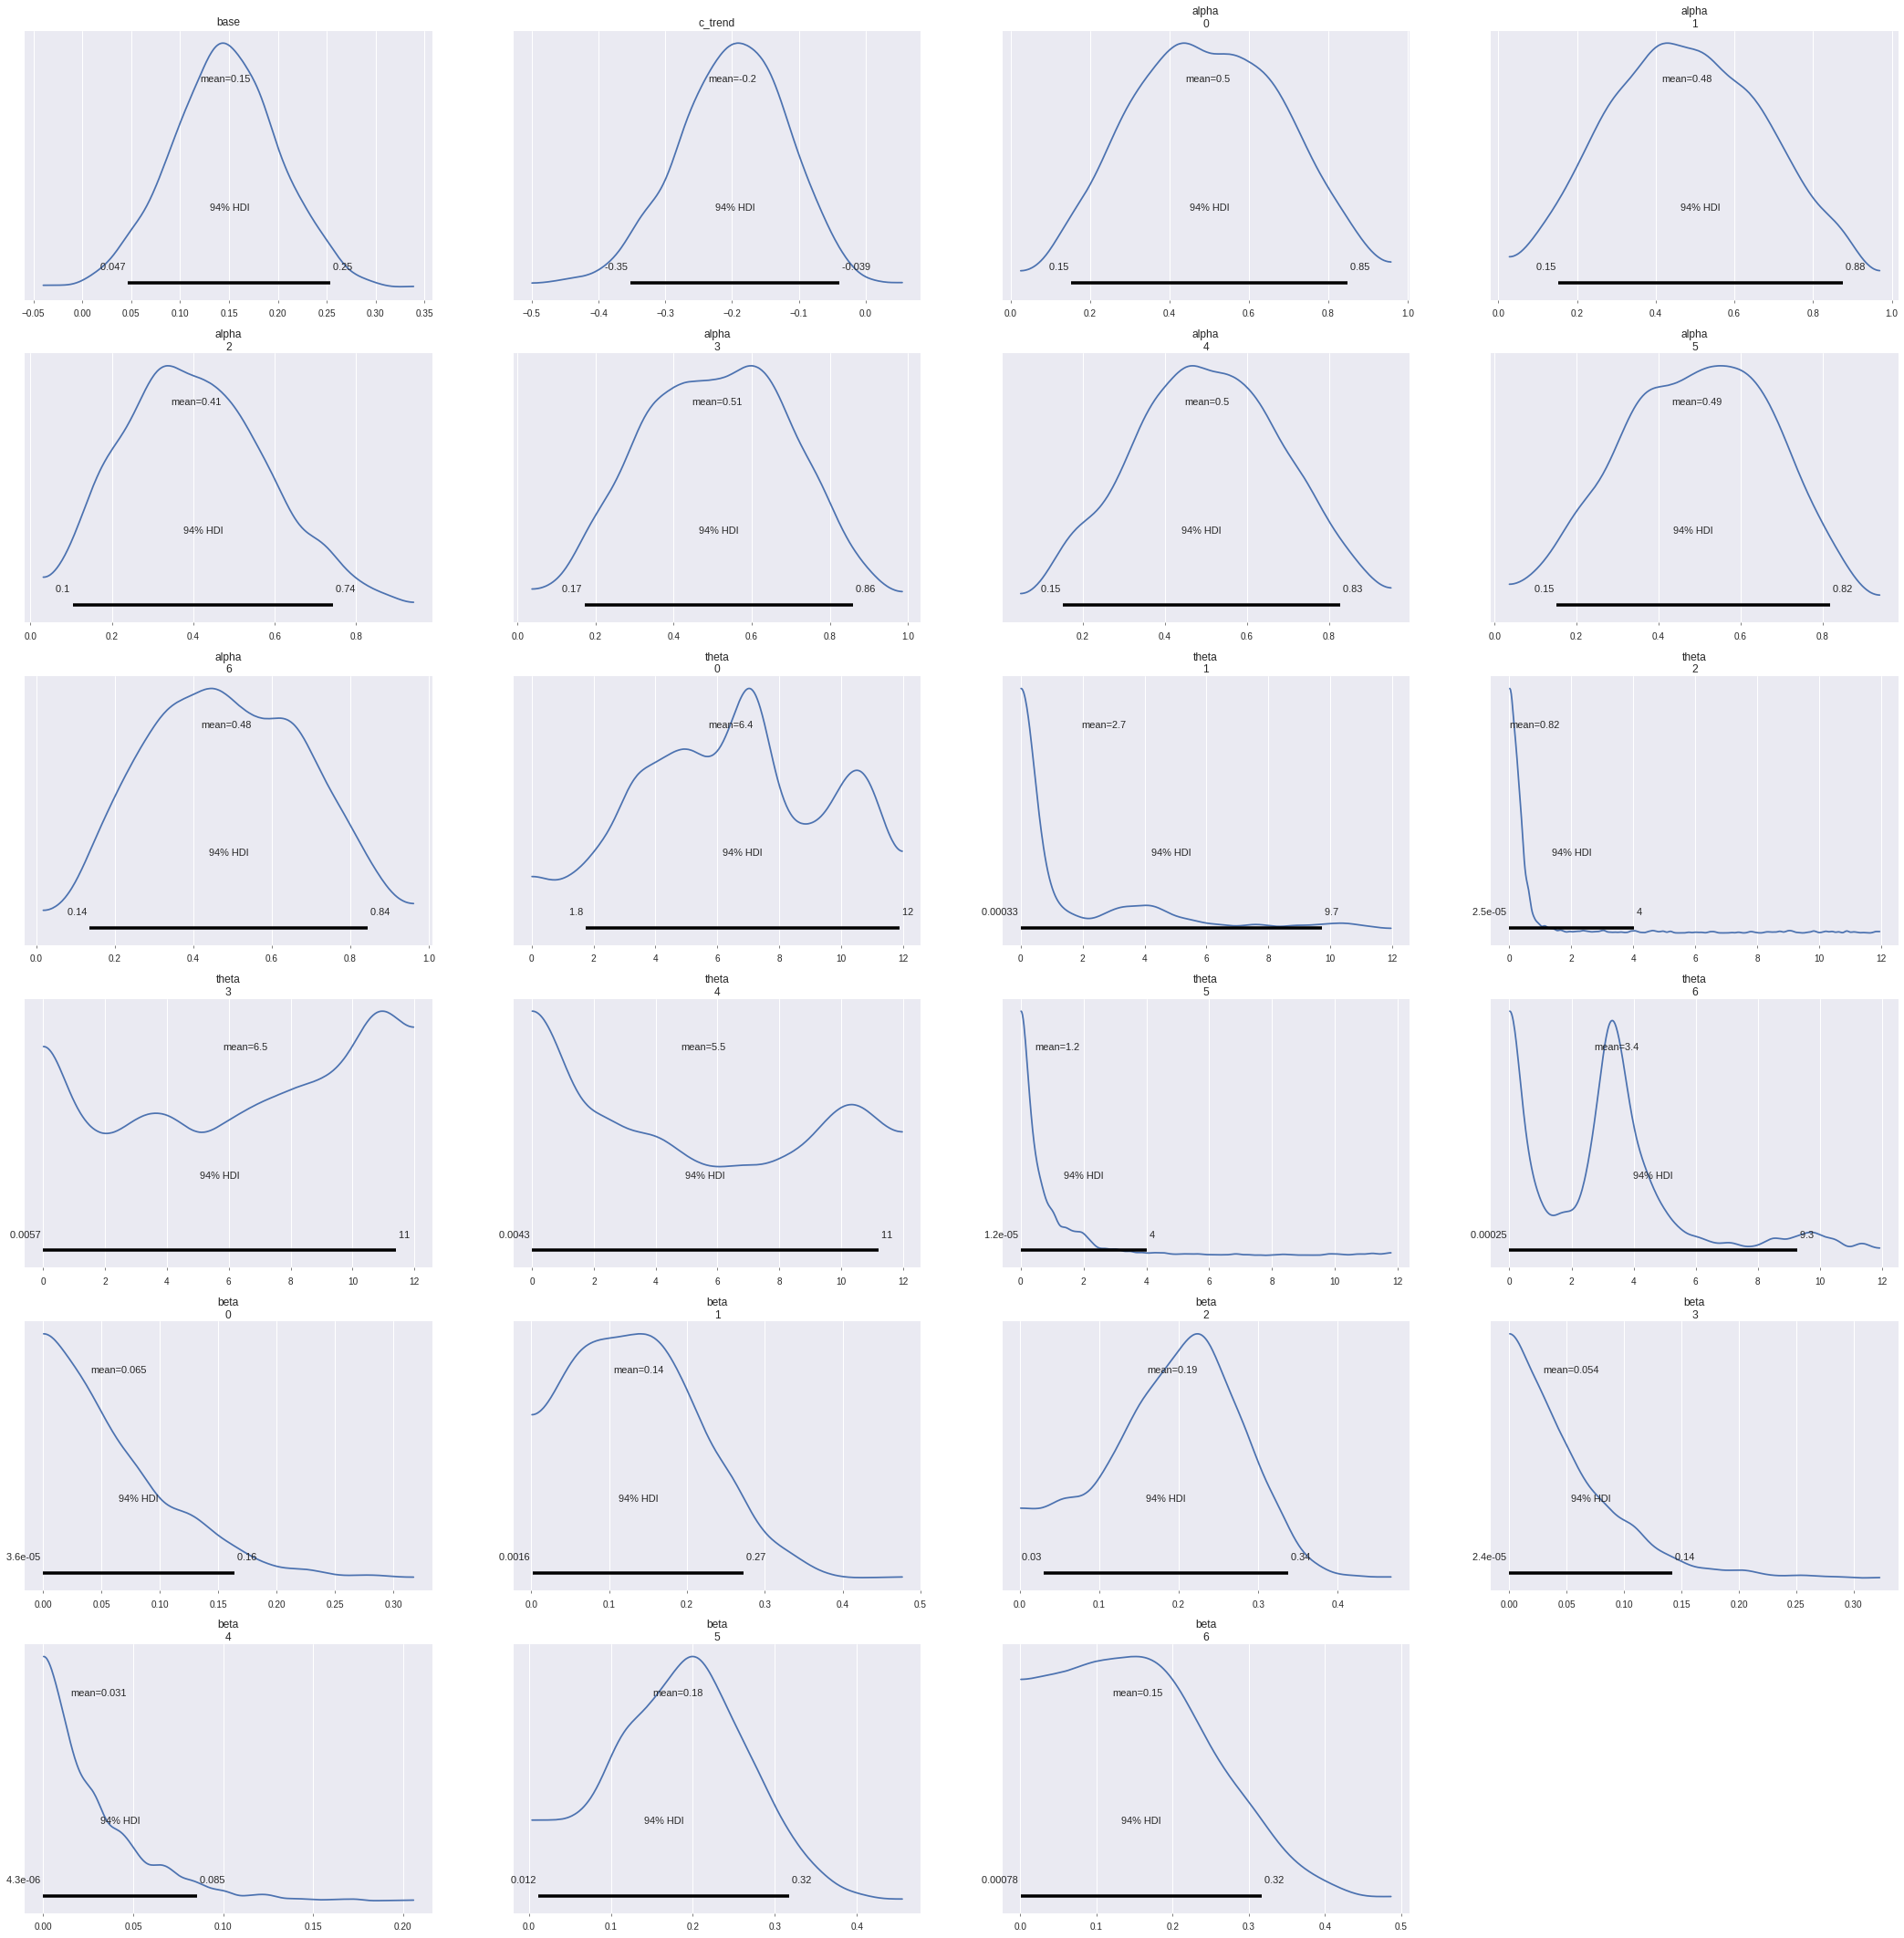

In [152]:
plt.style.use("seaborn")
az.plot_posterior(mmm_cst_trace,var_names=['base','c_trend','alpha','theta','beta'])

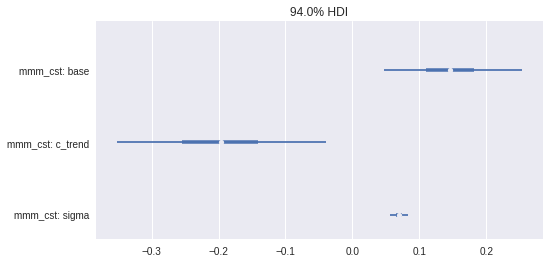

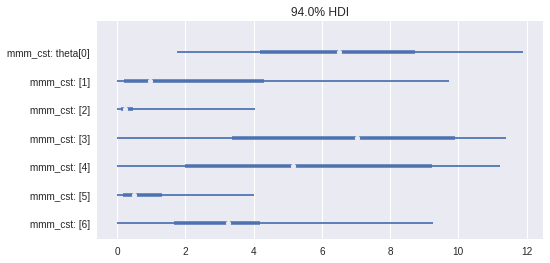

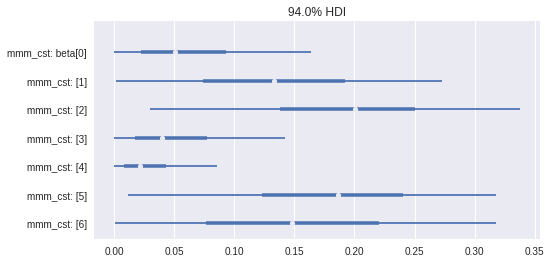

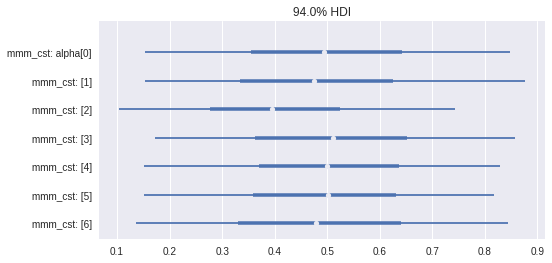

In [153]:
axes = az.plot_forest(
    data=[mmm_cst_trace],
    model_names=["mmm_cst"],
    var_names=["base", "c_trend", "sigma"],
    combined=True,
    figsize=(8, 4),
);
axes = az.plot_forest(
    data=[mmm_cst_trace],
    model_names=["mmm_cst"],
    var_names=["theta"],
    combined=True,
    figsize=(8, 4),
);
axes = az.plot_forest(
    data=[mmm_cst_trace],
    model_names=["mmm_cst"],
    var_names=["beta"],
    combined=True,
    figsize=(8, 4),
);
axes = az.plot_forest(
    data=[mmm_cst_trace],
    model_names=["mmm_cst"],
    var_names=["alpha"],
    combined=True,
    figsize=(8, 4),
);

In [154]:
percs = np.linspace(51, 99, 100)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
palette = "viridis_r"
cmap = plt.get_cmap(palette)

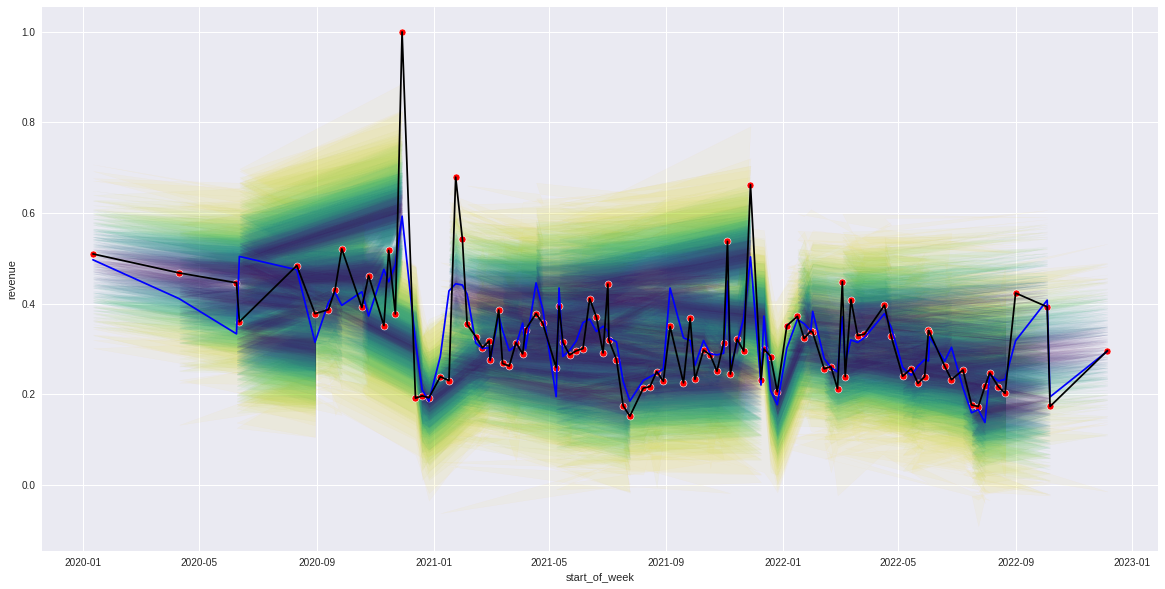

In [155]:
fig,ax=plt.subplots(figsize=(20,10))
for i, p in enumerate(percs[::-1]):
    upper = np.percentile(_sample(pp_mmm_cst["y_cst"], 104).T, p, axis=1)
    lower = np.percentile(_sample(pp_mmm_cst["y_cst"], 104).T, 100 - p, axis=1
    )
    color_val = colors[i]
    ax.fill_between(
        x=Y['start_of_week'],
        y1=upper.flatten(),
        y2=lower.flatten(),
        color=cmap(color_val),
        alpha=0.05,
    )
sns.lineplot(
    x=Y['start_of_week'],
    y=_sample(pp_mmm_cst["y_cst"], 104).T.mean(axis=1),
    color='blue'
)
sns.lineplot(
    x=Y["start_of_week"], 
    y=Y["revenue"], 
    color="k",
)
sns.scatterplot(
    x=Y["start_of_week"], 
    y=Y["revenue"], 
    color="red",
)

### 4.1.3 Analysis Model 1 (Trend, Seasonality and Carryover)

**General Features**

Here we just give the mean values. By considering the sd, we get a wider range as seen in the graphics above.

Base=0.145

The slope of the line that gives us the trend is -0.20. This shows that teh revenue is decreasing. 

We now give the feaures for each channel:
ROI(Return of Investment) is computed as:

$ROI_i$=sales_from_channel_i /total_spendings_on_i
Here $\alpha_i$ is the decay rate and $\theta_i$ is the delay measure in days of the peak effect. 

We compute it here:


In [161]:
print(mmm_cst_trace.posterior['channel_1'].stack(sample=('chain','draw')).mean(axis=1).sum()*(data['revenue'].max())/data['spend_channel_1'].sum())
print(mmm_cst_trace.posterior['channel_2'].stack(sample=('chain','draw')).mean(axis=1).sum()*(data['revenue'].max())/data['spend_channel_2'].sum())
print(mmm_cst_trace.posterior['channel_3'].stack(sample=('chain','draw')).mean(axis=1).sum()*(data['revenue'].max())/data['spend_channel_3'].sum())
print(mmm_cst_trace.posterior['channel_4'].stack(sample=('chain','draw')).mean(axis=1).sum()*(data['revenue'].max())/data['spend_channel_4'].sum())
print(mmm_cst_trace.posterior['channel_5'].stack(sample=('chain','draw')).mean(axis=1).sum()*(data['revenue'].max())/data['spend_channel_5'].sum())
print(mmm_cst_trace.posterior['channel_6'].stack(sample=('chain','draw')).mean(axis=1).sum()*(data['revenue'].max())/data['spend_channel_6'].sum())
print(mmm_cst_trace.posterior['channel_7'].stack(sample=('chain','draw')).mean(axis=1).sum()*(data['revenue'].max())/data['spend_channel_7'].sum())

<xarray.DataArray 'channel_1' ()>
array(3.18288575)
<xarray.DataArray 'channel_2' ()>
array(34.74279087)
<xarray.DataArray 'channel_3' ()>
array(1.60883893)
<xarray.DataArray 'channel_4' ()>
array(0.94893403)
<xarray.DataArray 'channel_5' ()>
array(0.38176727)
<xarray.DataArray 'channel_6' ()>
array(2.25741502)
<xarray.DataArray 'channel_7' ()>
array(0.81106293)


We then get 

**Channel 1**

$ROI_1=3.18$, 

$\theta_1=6.43$, 

$\alpha_1=0.49$

**Channel 2**

$ROI_2=34.74$,

$\theta_2=2.68$,

$\alpha_2=0.48$

**Channel 3**

$ROI_3=1.60$, 

$\theta_3=0.82$, 

$\alpha_3=0.40$

**Channel 4**

$ROI_4=0.94$,

$\theta_4=6.52$,

$\alpha_4=0.51$

**Channel 5**

$ROI_5=0.38 $, 

$\theta_5=5.53$,

$\alpha_5=0.50$

**Channel 6**

$ROI_6=2.25$, 

$\theta_6=1.16$, 

$\alpha_6=0.49$

**Channel 7**

$ROI_7=0.81$, 

$\theta_7=3.44$, 

$\alpha_7=0.48$


From our first figures, we have that the channels with a higher spend our number 7 and number 3. The spend on channels 1,5,6 have been decresing and on nuber 2 slightly increasing. 

The revenue is clearly decreasing, more precisely the negative slope of the trend confirms this tendency. We could capture some seasonality. 

Channels 4,5,7 have ROIs under 1, which would suggest that we are losing money with those channels. Channel 2 has a particularly high ROI with this model.
Channel 1,3 and 6 have a ROI bigger than 1.




All channels have a similar decay rates. 


## 4.2 Model 2 (Trend, Seasonality, Carryover, Saturation and Diminishing returns)

We now give our second models. The reason of our choices for priors are explained above. We slightly change some of them. 

### Priors

1. For the base, we choose a pm.Normal(0,2.5)
2. For the noise, we choose a pm.HalfNormal(0.005)
3. For c_trend, we choose a pm.Normal(0,0.5)
4. For c_seasonality, we choose a pm.Normal(0,0.025)
5. For $\beta_m$, we choose a pm.HalfNormal(0.5)
For $\alpha$ and $\theta$ as in model 1. Moreover, we get $\mathcal{K}$ as $kappa$ with a pm.Beta(2,2) and $\mathcal{S}$ as slope with a pm.Gamma(3,1).


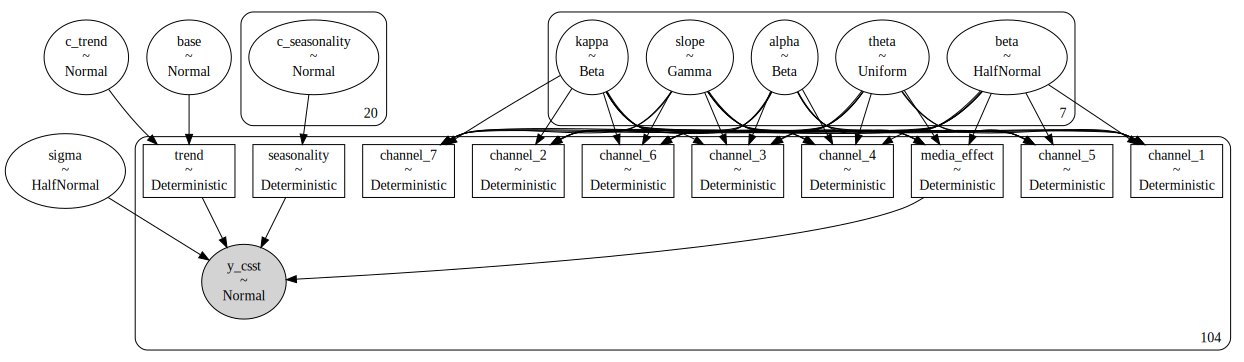

In [162]:
coords = {"fourier_features": np.arange(2 * n_order)}

with pm.Model(coords=coords) as mmm_csst:
    #Priors
    #base
    base=pm.Normal(name='base',mu=0, sigma=2.5)
    #trend
    c_t=pm.Normal(name='c_trend',mu=0, sigma=0.5)
    #seasonality
    c_seasonality=pm.Normal(name='c_seasonality',mu=0, sigma=0.025, dims='fourier_features') 
    #carryover
    alpha = pm.Beta('alpha', 3, 3 , shape=X.shape[1]) # retain rate in adstock 
    theta = pm.Uniform('theta',0 ,12, shape=X.shape[1]) #pick/delay of media impact
    #media_ffect
    beta= pm.HalfNormal('beta', 0.5,  shape=X.shape[1]) #media_coefficients
    #saturation and shape effect
    kappa=pm.Beta('kappa',2,2, shape=X.shape[1])    
    slope=pm.Gamma('slope', 3, 1, shape=X.shape[1])

    #parametrization
    trend = pm.Deterministic("trend",base + c_t*t)
    seasonality = pm.Deterministic(
        "seasonality", pm.math.dot(c_seasonality, fourier_features.to_numpy().T))
    computations = []
    for idx,col in enumerate(X.columns):
        comp = Hill(delayed_adstock(x=X[col].values, 
                                                alpha=alpha[idx],
                                                theta=theta[idx],
                                                L=13),slope[idx],kappa[idx])*beta[idx]
                    
        computations.append(comp)
    media_effect=pm.Deterministic('media_effect', sum(computations))
    channel_1=pm.Deterministic('channel_1', computations[0])
    channel_2=pm.Deterministic('channel_2', computations[1])
    channel_3=pm.Deterministic('channel_3', computations[2])
    channel_4=pm.Deterministic('channel_4', computations[3])
    channel_5=pm.Deterministic('channel_5', computations[4])
    channel_6=pm.Deterministic('channel_6', computations[5])
    channel_7=pm.Deterministic('channel_7', computations[6])

    
    #likelihood
    sigma = pm.HalfNormal('sigma',0.005)
    mu = sigma + media_effect+ trend+seasonality
    y_csst = pm.Normal('y_csst', mu=mu, sigma=sigma, observed=y)
  
    mmm_csst_prior_predictive = pm.sample_prior_predictive()
pm.model_to_graphviz(model=mmm_csst)


## 4.2.1 Prior checks


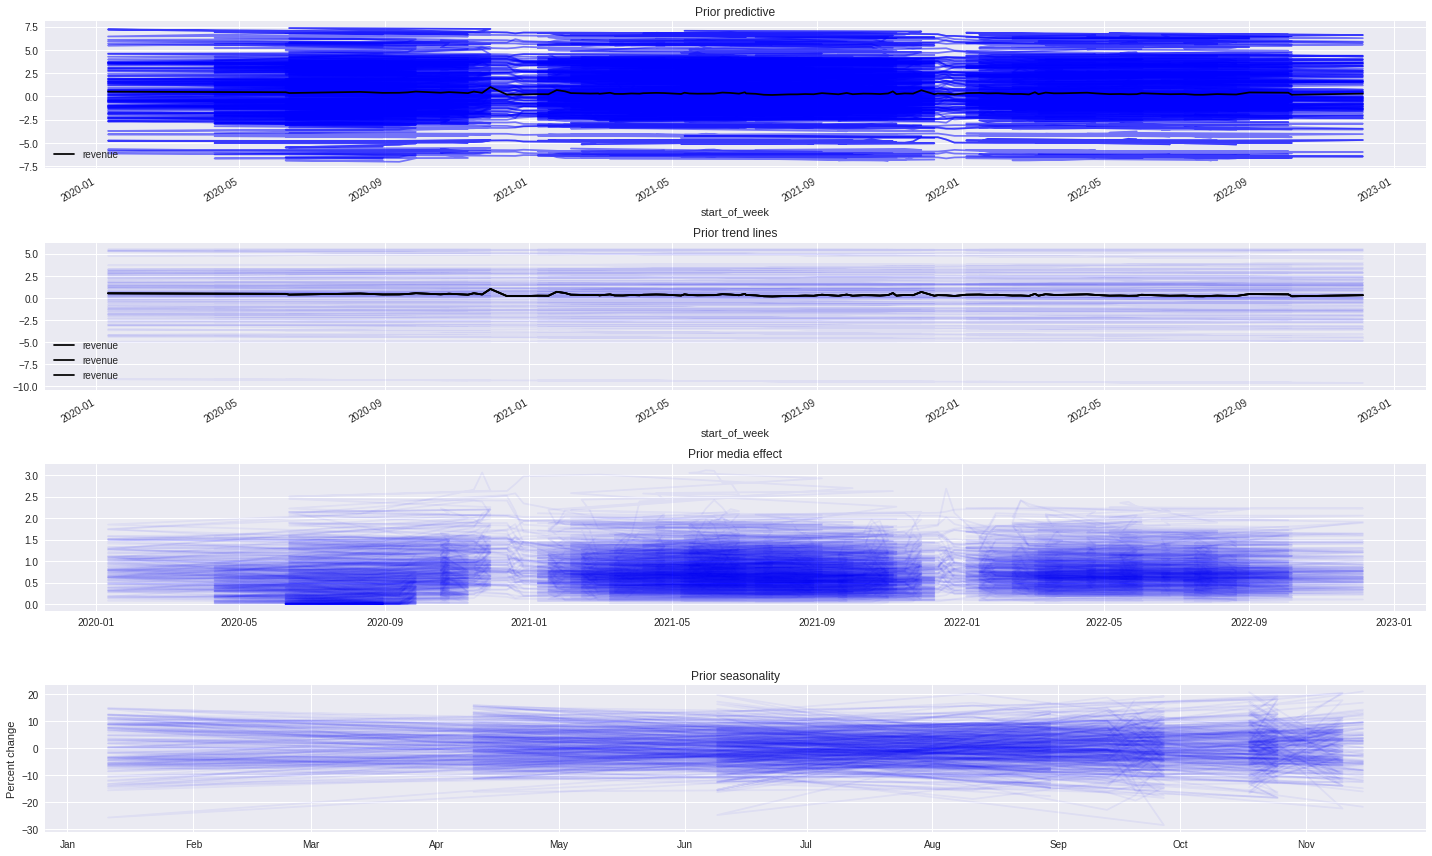

In [163]:
#Verifying priors
plt.style.use("seaborn") 

fig, ax = plt.subplots(nrows=4, ncols=1, sharex=False, figsize=(20, 12))
ax[0].plot(
    Y["start_of_week"],
    _sample(mmm_csst_prior_predictive['y_csst'], 100).T,
    color="blue",
    alpha=0.5,
)

Y.plot.line(x="start_of_week", y="revenue", color="k", ax=ax[0])
ax[0].set_title("Prior predictive");
ax[1].plot(
    Y["start_of_week"], _sample(mmm_csst_prior_predictive["trend"], 104).T , color="blue", alpha=0.05
)
Y.plot.line(x="start_of_week", y="revenue", color="k", ax=ax[1])
ax[1].set_title("Prior trend lines");
ax[2].plot(
    Y["start_of_week"], _sample(mmm_csst_prior_predictive["media_effect"], 104).T , color="blue", alpha=0.05
)
Y.plot.line(x="start_of_week", y="revenue", color="k", ax=ax[1])
ax[2].set_title("Prior media effect")
Y.plot.line(x="start_of_week", y="revenue", color="k", ax=ax[1]);

ax[3].plot(
    Y["start_of_week"].iloc[:12],
    _sample(mmm_csst_prior_predictive["seasonality"][:, :12], 100).T * 100,
    color="blue",
    alpha=0.05,
)
ax[3].set_title("Prior seasonality")
ax[3].set_ylabel("Percent change")
formatter = mdates.DateFormatter("%b")
ax[3].xaxis.set_major_formatter(formatter);
fig.tight_layout()

Once again, our prior look reasonable.

We now fit our model. We use PyMC and MCMC to produce our posterior.


In [167]:
with mmm_csst:
    mmm_csst_trace = pm.sample(1000, chains=2, return_inferencedata=True,tune=2000, target_accept=0.95)
    pp_mmm_csst= pm.sample_posterior_predictive(trace=mmm_csst_trace)

ERROR:pymc3:There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 12 divergences after tuning. Increase `target_accept` or reparameterize.


## 4.2.2 Posteriori checks

We did not manage to tune enough the model not to get divergences, however the divergences are not many and could be false positives. It is work in progress but we still try to get some information about our data.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7f64530750>,
      dtype=object)

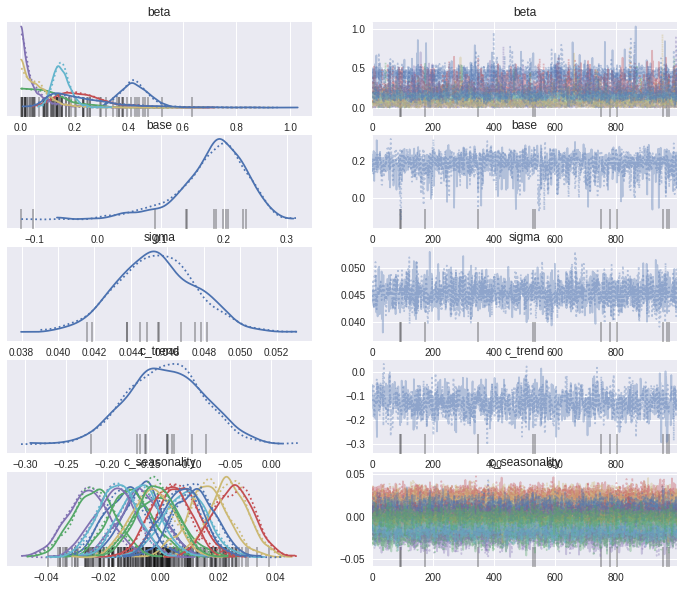

In [ ]:
plt.style.use("seaborn")
az.plot_trace(data=mmm_csst_trace, var_names=['beta','base','sigma','c_trend','c_seasonality'])

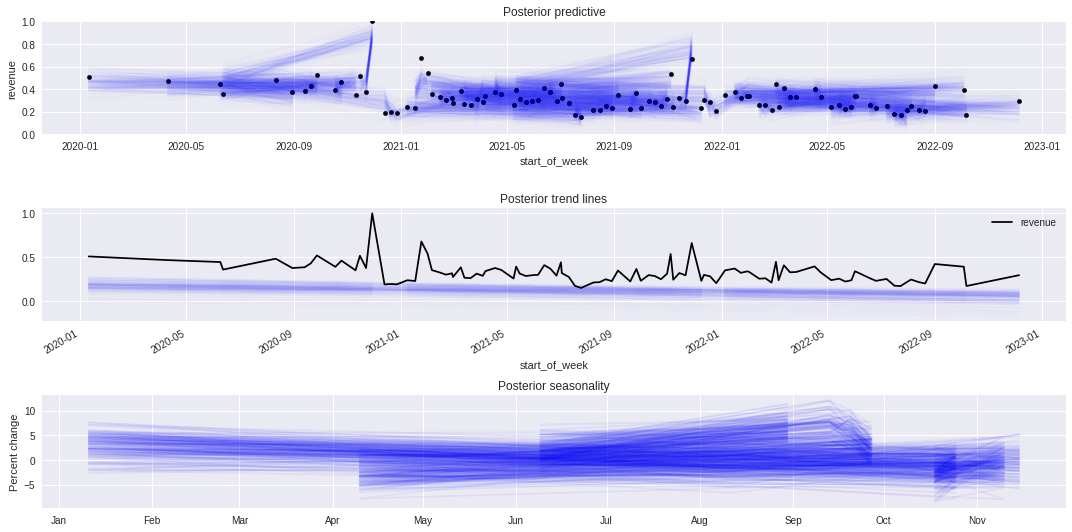

In [ ]:
plt.style.use("seaborn")

fig, ax = plt.subplots(nrows=3, ncols=1, sharex=False, figsize=(15, 7.5))
ax[0].plot(
    Y["start_of_week"],
    _sample(pp_mmm_csst["y_csst"], 104).T ,
    color="blue",
    alpha=0.01,
)
Y.plot.scatter(x="start_of_week", y="revenue", color="k", ax=ax[0])
ax[0].set_title("Posterior predictive")
ax[0].set_ylim([0, 1]);

posterior_trend = mmm_csst_trace.posterior["trend"].stack(sample=("draw", "chain")).T
ax[1].plot(data["start_of_week"], _sample(posterior_trend, 104).T , color="blue", alpha=0.01)
Y.plot.line(x="start_of_week", y="revenue", color="k", ax=ax[1])
ax[1].set_title("Posterior trend lines");
posterior_seasonality = (
    mmm_csst_trace.posterior["seasonality"].stack(sample=("draw", "chain")).T
)

ax[2].plot(
    Y["start_of_week"].iloc[:12],
    _sample(posterior_seasonality[:, :12], 100).T * 100,
    color="blue",
    alpha=0.05,
)
ax[2].set_title("Posterior seasonality")
ax[2].set_ylabel("Percent change")
formatter = mdates.DateFormatter("%b")
ax[2].xaxis.set_major_formatter(formatter);
fig.tight_layout()

In [ ]:
pm.summary(mmm_csst_trace, var_names=['base','alpha','theta','beta','sigma','c_trend','slope','kappa'])


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
base       0.179  0.059   0.067    0.278      0.002    0.001    1098.0   
alpha[0]   0.173  0.085   0.040    0.332      0.002    0.001    1486.0   
alpha[1]   0.498  0.187   0.182    0.861      0.003    0.002    3171.0   
alpha[2]   0.303  0.140   0.068    0.561      0.003    0.002    2148.0   
alpha[3]   0.498  0.192   0.136    0.825      0.003    0.003    3084.0   
alpha[4]   0.474  0.189   0.146    0.826      0.004    0.003    2429.0   
alpha[5]   0.565  0.123   0.334    0.779      0.003    0.002    1592.0   
alpha[6]   0.624  0.209   0.265    0.956      0.010    0.008     383.0   
theta[0]   7.096  0.103   6.904    7.285      0.003    0.002    1644.0   
theta[1]   3.833  4.117   0.000   10.546      0.318    0.225     223.0   
theta[2]   0.163  0.137   0.000    0.402      0.003    0.002    1823.0   
theta[3]   6.895  3.306   1.049   11.986      0.100    0.073    1190.0   
theta[4]   4.811  4.223   0.000   11.123      0.246    0.174     359.0   
theta[5]   0.308  0.247   0.000    0.742      0.008    0.006    1200.0   
theta[6]   3.456  0.956   1.737    4.993      0.056    0.040     341.0   
beta[0]    0.420  0.052   0.323    0.520      0.001    0.001    1544.0   
beta[1]    0.104  0.079   0.000    0.246      0.003    0.002     567.0   
beta[2]    0.232  0.101   0.073    0.433      0.003    0.002    1313.0   
beta[3]    0.051  0.073   0.000    0.160      0.002    0.002     977.0   
beta[4]    0.066  0.067   0.000    0.173      0.002    0.001    1075.0   
beta[5]    0.151  0.032   0.092    0.209      0.001    0.001     970.0   
beta[6]    0.235  0.138   0.045    0.508      0.006    0.004     558.0   
sigma      0.045  0.002   0.042    0.050      0.000    0.000    2135.0   
c_trend   -0.129  0.048  -0.217   -0.042      0.002    0.001     806.0   
slope[0]  12.013  2.590   7.319   16.790      0.055    0.039    2111.0   
slope[1]   3.498  1.598   0.613    6.454      0.043    0.031    1119.0   
slope[2]   2.229  1.237   0.383    4.485      0.040    0.028     860.0   
slope[3]   3.480  2.089   0.374    7.385      0.050    0.036    1276.0   
slope[4]   3.588  2.165   0.269    7.456      0.072    0.055    1010.0   
slope[5]   5.216  1.929   1.620    8.740      0.046    0.032    1484.0   
slope[6]   4.688  1.787   1.949    8.162      0.059    0.042     822.0   
kappa[0]   0.560  0.029   0.510    0.618      0.001    0.001    1460.0   
kappa[1]   0.630  0.185   0.302    0.949      0.005    0.003    1436.0   
kappa[2]   0.620  0.193   0.297    0.966      0.005    0.004    1402.0   
kappa[3]   0.617  0.226   0.210    0.981      0.007    0.005    1196.0   
kappa[4]   0.588  0.218   0.230    0.960      0.007    0.005    1057.0   
kappa[5]   0.272  0.040   0.200    0.341      0.001    0.001    1103.0   
kappa[6]   0.618  0.137   0.400    0.878      0.004    0.003    1005.0   

          ess_tail  r_hat  
base        1136.0    1.0  
alpha[0]    1195.0    1.0  
alpha[1]    1646.0    1.0  
alpha[2]    1567.0    1.0  
alpha[3]    1409.0    1.0  
alpha[4]    1690.0    1.0  
alpha[5]    1442.0    1.0  
alpha[6]     480.0    1.0  
theta[0]    1306.0    1.0  
theta[1]    1003.0    1.0  
theta[2]    1127.0    1.0  
theta[3]    1025.0    1.0  
theta[4]     916.0    1.0  
theta[5]     867.0    1.0  
theta[6]     355.0    1.0  
beta[0]     1511.0    1.0  
beta[1]      659.0    1.0  
beta[2]     1287.0    1.0  
beta[3]     1181.0    1.0  
beta[4]     1118.0    1.0  
beta[5]     1040.0    1.0  
beta[6]      851.0    1.0  
sigma       1551.0    1.0  
c_trend     1320.0    1.0  
slope[0]    1437.0    1.0  
slope[1]     792.0    1.0  
slope[2]    1187.0    1.0  
slope[3]     843.0    1.0  
slope[4]     806.0    1.0  
slope[5]     960.0    1.0  
slope[6]    1298.0    1.0  
kappa[0]    1261.0    1.0  
kappa[1]    1062.0    1.0  
kappa[2]    1379.0    1.0  
kappa[3]     882.0    1.0  
kappa[4]    1407.0    1.0  
kappa[5]     944.0    1.0  
kappa[6]     997.0    1.0

Once again we see that $r_{hat}\leq 1.01$ and $ess_{bulk},$ $ess_{tail}$ are big enough. However some of the $mcse_{mean}$ of theta are not optimal. 

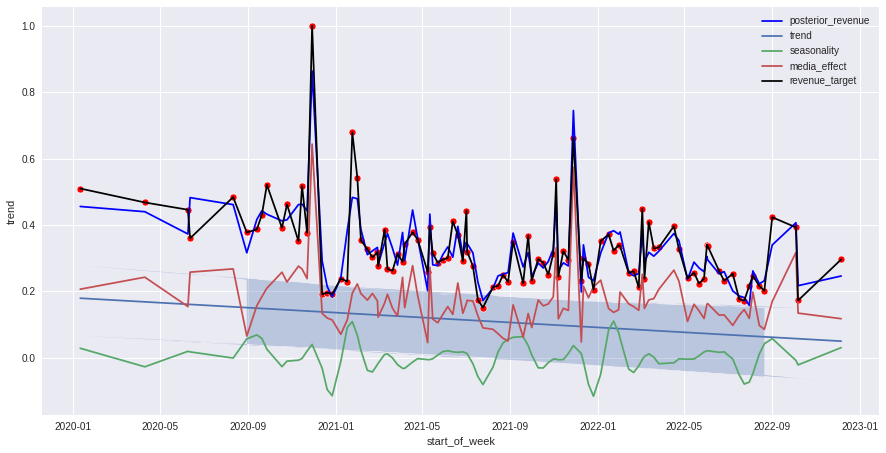

In [ ]:
model_hdi=az.hdi(ary=mmm_csst_trace,)
fig,ax=plt.subplots(figsize=(15, 7.5))

ax.fill_between(
    x=Y['start_of_week'],
    y1=model_hdi['trend'][:,0],
    y2=model_hdi['trend'][:,1],
    alpha=0.3,
)

sns.lineplot(
    x=Y['start_of_week'],
    y=_sample(pp_mmm_csst["y_csst"], 104).T.mean(axis=1),
    color='blue',
    label='posterior_revenue'
)

sns.lineplot(
    x=Y['start_of_week'],
    y=mmm_csst_trace.posterior['trend'].stack(sample=('chain','draw')).mean(axis=1),
    label='trend',
    
)

sns.lineplot(
    x=Y['start_of_week'],
    y=mmm_csst_trace.posterior['seasonality'].stack(sample=('chain','draw')).mean(axis=1),
    label='seasonality'
)

sns.lineplot(
    x=Y['start_of_week'],
    y=mmm_csst_trace.posterior['media_effect'].stack(sample=('chain','draw')).mean(axis=1),
    label='media_effect'
)
sns.lineplot(
    x=Y["start_of_week"], 
    y=Y["revenue"], 
    color="k", 
    label='revenue_target'
)
sns.scatterplot(
    x=Y["start_of_week"], 
    y=Y["revenue"], 
    color="red",

)

## 4.2.3 Analysis of Model 2 (Trend, Seasonality, Carryover, Saturation and diminishing returns)

Base=0.17

The slope of the line that gives us the trend is -0.129. This shows that the tendency of the revenue to decrease. 

We now compute the ROI:



In [168]:
print(mmm_csst_trace.posterior['channel_1'].stack(sample=('chain','draw')).mean(axis=1).sum()*(data['revenue'].max())/data['spend_channel_1'].sum())
print(mmm_csst_trace.posterior['channel_2'].stack(sample=('chain','draw')).mean(axis=1).sum()*(data['revenue'].max())/data['spend_channel_2'].sum())
print(mmm_csst_trace.posterior['channel_3'].stack(sample=('chain','draw')).mean(axis=1).sum()*(data['revenue'].max())/data['spend_channel_3'].sum())
print(mmm_csst_trace.posterior['channel_4'].stack(sample=('chain','draw')).mean(axis=1).sum()*(data['revenue'].max())/data['spend_channel_4'].sum())
print(mmm_csst_trace.posterior['channel_5'].stack(sample=('chain','draw')).mean(axis=1).sum()*(data['revenue'].max())/data['spend_channel_5'].sum())
print(mmm_csst_trace.posterior['channel_6'].stack(sample=('chain','draw')).mean(axis=1).sum()*(data['revenue'].max())/data['spend_channel_6'].sum())
print(mmm_csst_trace.posterior['channel_7'].stack(sample=('chain','draw')).mean(axis=1).sum()*(data['revenue'].max())/data['spend_channel_7'].sum())

<xarray.DataArray 'channel_1' ()>
array(3.28611031)
<xarray.DataArray 'channel_2' ()>
array(10.11051566)
<xarray.DataArray 'channel_3' ()>
array(1.71919195)
<xarray.DataArray 'channel_4' ()>
array(0.31348635)
<xarray.DataArray 'channel_5' ()>
array(0.50297365)
<xarray.DataArray 'channel_6' ()>
array(2.89361935)
<xarray.DataArray 'channel_7' ()>
array(0.44050676)


**Channel 1**

$ROI_1=3.28$,

$\theta_1=7.09$, 

$\alpha_1=0.17$


**Channel 2**

$ROI_2=10.11$,

$\theta_2=3.17$,

$\alpha_2=0.48$



**Channel 3**

$ROI_3=1.71$,

$\theta_3=0.15$,

$\alpha_3=0.29$



**Channel 4**

$ROI_4=0.031$,

$\theta_4=6.77$,

$\alpha_4=0.50$



**Channel 5**

$ROI_5=0.50 $,

$\theta_5=5.05$,

$\alpha_5=0.48$



**Channel 6**

$ROI_6=2.89$,

$\theta_6=0.38$,

$\alpha_6=0.55$



**Channel 7**

$ROI_7=0.44$,

$\theta_7=3.54$,

$\alpha_7=0.59$


### Final conclusions:

The second model agrees in some sense with the first one. 
Channels 4,5,7 have ROIs under 1, which would suggest that we are losing money with those channels. Channel 2 has a high ROI but is a bit more reasonable than in the first model.
Channel 1,6,3 have a ROI bigger that 1. 

Moreover, the second channel is the one with the best performance in terms of ROI. 


All channels have a similar decay rates.

Disclaimer: I did not have enough time to study the saturation of each channel. 



